In [1]:
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
import json
from datetime import datetime

In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)

# Define run

In [3]:
with open('single_run_number.json', 'r') as file:
    run_config = json.load(file)

run_number = run_config.get("run_number")
ora_attuale = datetime.now().time()

print(f"Run number: {run_number} -- ultimo aggiornamento : {ora_attuale.strftime('%H:%M:%S')}")

Run number: 730267 -- ultimo aggiornamento : 00:13:03


In [4]:
d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x1 = 0.06456238617170831  
offset_y1 = -2.1334698564435857

offset_x3 =   0.49078668175406326
offset_y3 =   -2.05

range_chamber = ((-5,15),(-5,15))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

## can modify the cherenkov thresholds  ##
th_cherry1 = 20
th_cherry2 = 20
###########################################

# data_path =f'../data/TB_T9_2025/run{run_number}.h5'
data_path =f'/eos/project/i/insulab-como/testBeam/TB_2025_06_T9_epBOOST/HDF5/run{run_number}.h5'
# print('opening ', data_path) 
pos = []
phs = []
tmis =[]
qtots =[]
nclus = []
info_pluss =[]
xinfos =[]
with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
    # print(hf.keys())
    hf["xpos"].shape
    keys = list(hf.keys())
    pos.append(np.array(hf['xpos']))
    phs.append(np.array(hf['digiPH'])) # from 24
    tmis.append(np.array(hf['digiTime'])) # from 24
    qtots.append(np.array(hf['qtot'])) # from 24
    nclus.append(np.array(hf['nclu'])) # from 24
    info_pluss.append(np.array(hf['info_plus']))
    xinfos.append(np.array(hf['xinfo']))
    #for k in hf.keys():
    #    comand = f'{k} = np.array(hf["{k}"])'
        # print(comand)
    #  exec(comand)
xpos = np.concatenate(pos,axis=0)
ph = np.concatenate(phs,axis=0)
tm = np.concatenate(tmis,axis=0)
qtot = np.concatenate(qtots,axis=0)
nclu = np.concatenate(nclus,axis=0)
info_plus = np.concatenate(info_pluss,axis=0)
xinfo = np.concatenate(xinfos,axis=0)

# print('######## PRE PURGE############')
# print('xpos shape', xpos.shape)

# fig, ax = plt.subplots(2, figsize=(8, 8))

# for i in range(xpos.shape[1]):
#     # Histogram completo (tutti i valori)
#     h_all = np.histogram(xpos[:, i], bins=1000)
#     ax[0].hist(xpos[:, i], bins=1000, histtype='step', label=f'xpos {i}')
#     total_all = np.sum(h_all[0])

#     # Histogram nella finestra [-1, 25]
#     h_good = np.histogram(xpos[:, i], bins=50, range=(-1, 25))
#     ax[1].hist(xpos[:, i], bins=50, range=(-1, 25), histtype='step', label=f'xpos {i}')
#     total_good = np.sum(h_good[0])

#     # Stampa riepilogo
#     print(f'xpos {i}: ALL = {total_all}, GOOD = {total_good}, FRACTION = {total_good / total_all:.3f}')

# for a in ax:
#     # a.set_yscale('log')  # scommenta se vuoi scala logaritmica
#     a.legend()

# plt.tight_layout()
# plt.show()

# print('##############################\n')

# print('N spill: ', info_plus[:,0][-1])
# print(np.unique(xinfo[:,1]))

# Applica la condizione su tutte le colonne da 0 a 4 
logic_pos = (xpos[:, :6] > -1) & (xpos[:, :6] < 15)

logic = logic_pos.all(axis = 1)
xpos= xpos[logic]
ph= ph[logic]
tm= tm[logic]
qtot= qtot[logic]
nclu= nclu[logic]
info_plus= info_plus[logic]
xinfo= xinfo[logic]
# print('######## POST PURGE############')
# print('xpos shape', xpos.shape)
# print('###############################\n')


xpos[:,0]= xpos[:,0] - offset_x1 
xpos[:,1]= xpos[:,1] - offset_y1 
xpos[:,4]= xpos[:,4] - offset_x3 
xpos[:,5]= xpos[:,5] - offset_y3 
    
x1 = xpos[:,0]
y1 = xpos[:,1]
x2 = xpos[:,2] 
y2 = xpos[:,3] 
x3 = xpos[:,4]
y3 = xpos[:,5]

# print(np.mean(x1),np.mean(y1),np.mean(x2),np.mean(y2),np.mean(x3),np.mean(y3))

Calibration = False
if Calibration:
    q = -25.84
    m = 323.4
    ph[:,2]=  (ph[:,2] - q)/m

xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)

ph_calo_photon = ph[:,2]
ph_cherry1 = ph[:,0]

theta_crit = 100000000000
if run_number in [730224,730245,730247]: ## add 6GeV runs
    theta_crit = np.sqrt((2*887/(6*1e9))) ##rad
if run_number in [730250,730251,730253]: ## add 2.866GeV runs
    theta_crit = np.sqrt((2*887/(2.86*1e9))) ##rad

CutTheta = False

if CutTheta == True:
    theta_cut = theta_crit
else:
    theta_cut = 100000000000
    
print(f'theta cut: ± {theta_cut*1e6:.2f} urad')

print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events in x1: {len(x1)}')

theta cut: ± 100000000000000000.00 urad
730267 -- N spill: 41 -- events in x1: 9857


# Xpos plots

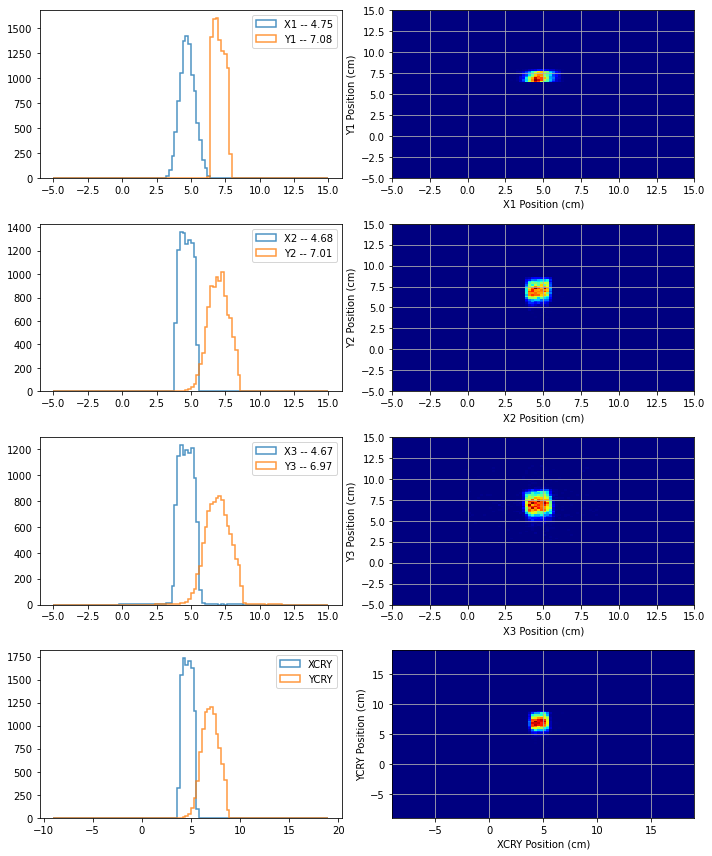

In [5]:
fig, ax = plt.subplots(4,2,figsize=(10, 12))
ax = ax.flatten()
ax[0].hist(xpos[:,0],range= range_chamber[0], bins=bins2d[0], label=f'X1 -- {np.mean(xpos[:,0]):.2f}', **opt_hist)
ax[0].hist(xpos[:,1],range= range_chamber[1], bins=bins2d[1], label=f'Y1 -- {np.mean(xpos[:,1]):.2f}', **opt_hist)
ax[0].legend()
ax[1].hist2d(xpos[:,0], xpos[:,1],range = range_chamber, **opts_2d)
ax[1].set_xlabel('X1 Position (cm)')
ax[1].set_ylabel('Y1 Position (cm)')
ax[1].grid()

ax[2].hist(xpos[:,2],range= range_chamber[0], bins=bins2d[0], label=f'X2 -- {np.mean(xpos[:,2]):.2f}', **opt_hist)
ax[2].hist(xpos[:,3],range= range_chamber[1], bins=bins2d[1], label=f'Y2 -- {np.mean(xpos[:,3]):.2f}', **opt_hist)
ax[2].legend()
ax[3].hist2d(xpos[:,2], xpos[:,3],range = range_chamber, **opts_2d)
ax[3].set_xlabel('X2 Position (cm)')
ax[3].set_ylabel('Y2 Position (cm)')
ax[3].grid()

ax[4].hist(xpos[:,4],range= range_chamber[0], bins=bins2d[0], label=f'X3 -- {np.mean(xpos[:,4]):.2f}', **opt_hist)
ax[4].hist(xpos[:,5],range= range_chamber[1], bins=bins2d[1], label=f'Y3 -- {np.mean(xpos[:,5]):.2f}', **opt_hist)
ax[4].legend()
ax[5].hist2d(xpos[:,4], xpos[:,5],range = range_chamber, **opts_2d)
ax[5].set_xlabel('X3 Position (cm)')
ax[5].set_ylabel('Y3 Position (cm)')
ax[5].grid()

ax[6].hist(xcry,range= (range_chamber[0][0]-4,range_chamber[0][1]+4), bins=bins2d[0], label='XCRY', **opt_hist)
ax[6].hist(ycry,range= (range_chamber[1][0]-4, range_chamber[1][1]+4), bins=bins2d[1], label='YCRY', **opt_hist)
ax[6].legend()
ax[7].hist2d(xcry, ycry,range =  ((range_chamber[0][0]-4,range_chamber[0][1]+4),(range_chamber[1][0]-4, range_chamber[1][1]+4)), **opts_2d)
ax[7].set_xlabel('XCRY Position (cm)')
ax[7].set_ylabel('YCRY Position (cm)')
ax[7].grid()

plt.tight_layout()
plt.show()

# Thetas

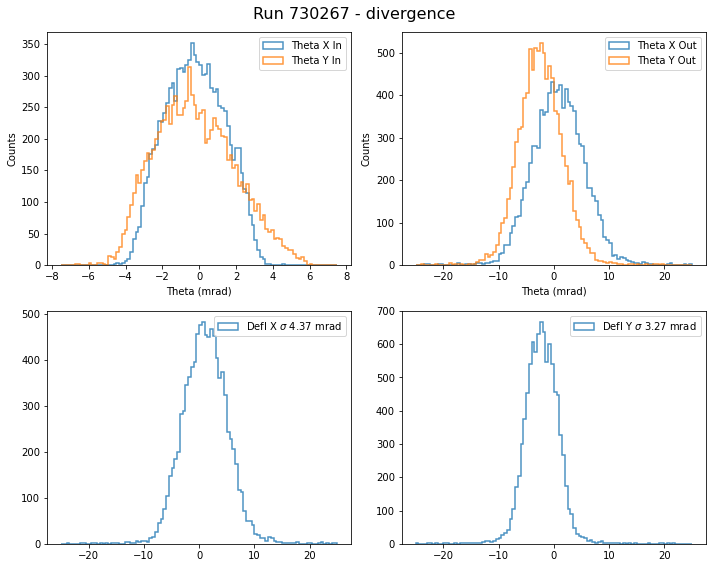

In [6]:
fig, ax = plt.subplots(2,2, figsize=(10, 8))
ax= ax.flatten()
fig.suptitle(f'Run {run_number} - divergence ', fontsize=16)

ax[0].hist(theta_x_in*1e3, bins=100, range=(-7.5, 7.5), label=f'Theta X In', **opt_hist)
ax[0].hist(theta_y_in*1e3, bins=100, range=(-7.5, 7.5), label=f'Theta Y In', **opt_hist)
ax[0].set_xlabel('Theta (mrad)')
ax[0].set_ylabel('Counts')

ax[1].hist(theta_x_out*1e3, bins=100, range=(-25, 25), label=f'Theta X Out', **opt_hist)
ax[1].hist(theta_y_out*1e3, bins=100, range=(-25, 25), label=f'Theta Y Out', **opt_hist)
ax[1].set_xlabel('Theta (mrad)')
ax[1].set_ylabel('Counts')

Defl_x = (theta_x_out-theta_x_in)*1e3
Defl_y = (theta_y_out-theta_y_in)*1e3

logi_single_cluster = ((nclu[:,0]==1) & (nclu[:,1]==1))
logi_deflx = logi_single_cluster & (Defl_x >-50) & (Defl_x <50)  
logi_defly = logi_single_cluster & (Defl_y >-50) & (Defl_y <50)  

ax[2].hist(Defl_x[logi_deflx], bins=100, range=(-25, 25), label=f'Defl X $\sigma$ {np.std(Defl_x[logi_deflx]):.2f} mrad', **opt_hist)
ax[3].hist(Defl_y[logi_defly], bins=100, range=(-25, 25), label=f'Defl Y $\sigma$ {np.std(Defl_y[logi_defly]):.2f} mrad', **opt_hist)

if CutTheta:
    ax[0].axvline(-theta_cut*1e3, c = 'r', ls = '--')
    ax[0].axvline(theta_cut*1e3, c = 'r', ls = '--', label = f'theta cut : $\pm${theta_cut*1e6:.2f} urad')
for a in ax:
    a.legend()
plt.tight_layout()
plt.show()

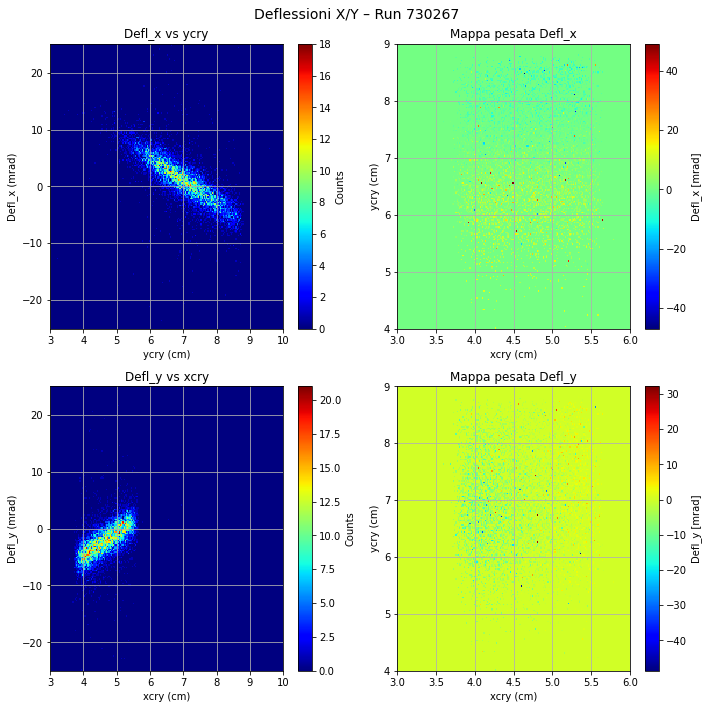

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
fig.suptitle(f"Deflessioni X/Y – Run {run_number}", fontsize=14)

# --- Defl_x vs ycry ---
h0 = ax[0].hist2d(ycry[logi_deflx], Defl_x[logi_deflx],
                  bins=200, range=((3, 10), (-25, 25)), cmap=mycmap)
ax[0].set_title("Defl_x vs ycry")
ax[0].set_xlabel("ycry (cm)")
ax[0].set_ylabel("Defl_x (mrad)")
ax[0].grid()
plt.colorbar(h0[3], ax=ax[0], label="Counts")

# --- Defl_x mappa pesata ---
h1 = ax[1].hist2d(xcry[logi_deflx], ycry[logi_deflx],
                  weights=Defl_x[logi_deflx], bins=200,
                  range=((3, 6), (4, 9)), cmap=mycmap)
ax[1].set_title("Mappa pesata Defl_x")
ax[1].set_xlabel("xcry (cm)")
ax[1].set_ylabel("ycry (cm)")
ax[1].grid()
plt.colorbar(h1[3], ax=ax[1], label="Defl_x [mrad]")

# --- Defl_y vs xcry ---
h2 = ax[2].hist2d(xcry[logi_defly], Defl_y[logi_defly],
                  bins=200, range=((3, 10), (-25, 25)), cmap=mycmap)
ax[2].set_title("Defl_y vs xcry")
ax[2].set_xlabel("xcry (cm)")
ax[2].set_ylabel("Defl_y (mrad)")
ax[2].grid()
plt.colorbar(h2[3], ax=ax[2], label="Counts")

# --- Defl_y mappa pesata ---
h3 = ax[3].hist2d(xcry[logi_defly], ycry[logi_defly],
                  weights=Defl_y[logi_defly], bins=200,
                  range=((3, 6), (4, 9)), cmap=mycmap)
ax[3].set_title("Mappa pesata Defl_y")
ax[3].set_xlabel("xcry (cm)")
ax[3].set_ylabel("ycry (cm)")
ax[3].grid()
plt.colorbar(h3[3], ax=ax[3], label="Defl_y [mrad]")

plt.tight_layout()
plt.show()


# Signals

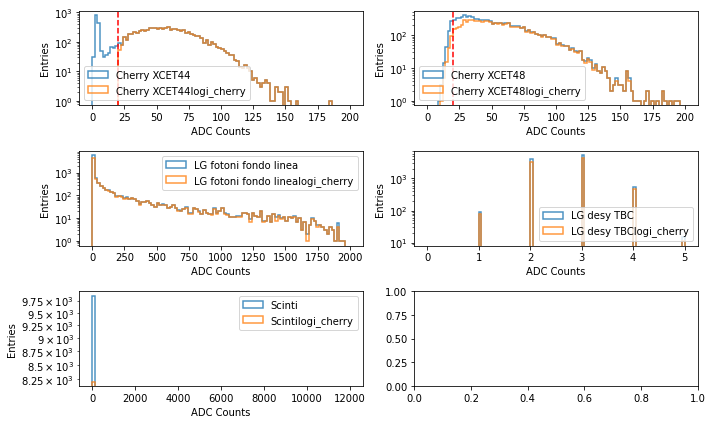

In [8]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_Ph = [
    (0, 200),
    (0, 200),
    (0, 2000),
    (0, 5),
    (0, 12000)
]

for i in range(5):
    ax[i].hist(ph[:,i],range=ranges_Ph[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
for i in range(5):
    ax[i].hist(ph[:,i][ph_cherry1>th_cherry1],range=ranges_Ph[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('ADC Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_yscale('log')
    
ax[0].axvline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
ax[1].axvline(th_cherry2, color='red', linestyle='--', label='Threshold Cherry 2')
plt.tight_layout()
plt.show()

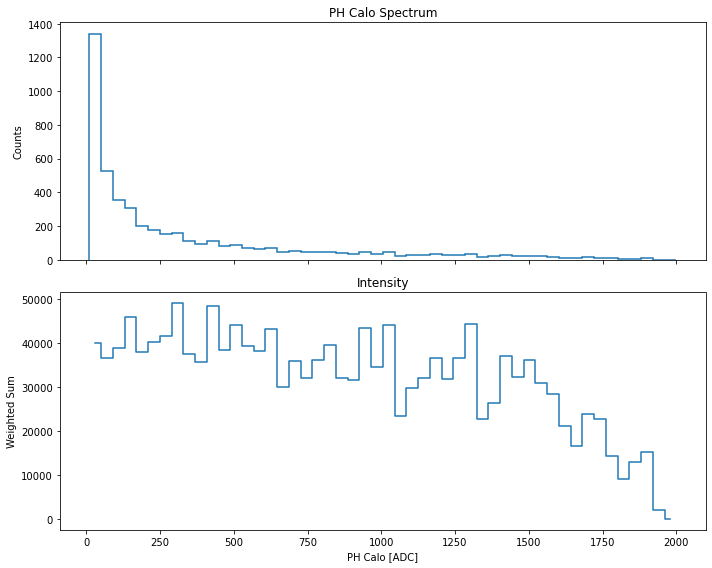

In [9]:
fig, ax = plt.subplots(2, figsize=(10, 8), sharex=True)

# Parametri istogramma
bins = 50
opt_hist = dict(histtype='step', linewidth=1.5)
rng_plot_calo=(10,ranges_Ph[2][1])

# === Primo istogramma: distribuzione originale ===
ax[0].hist(ph_calo_photon, bins=bins, range=rng_plot_calo, **opt_hist)
ax[0].set_title("PH Calo Spectrum")
ax[0].set_ylabel("Counts")

# === Secondo istogramma: PH × centro del bin ===
counts, bin_edges = np.histogram(ph_calo_photon, bins=bins, range=rng_plot_calo)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
spectral_intensity = counts * bin_centers

ax[1].step(bin_centers, spectral_intensity, where='mid')
ax[1].set_title("Intensity")
ax[1].set_xlabel("PH Calo [ADC]")
ax[1].set_ylabel("Weighted Sum")

plt.tight_layout()
plt.show()


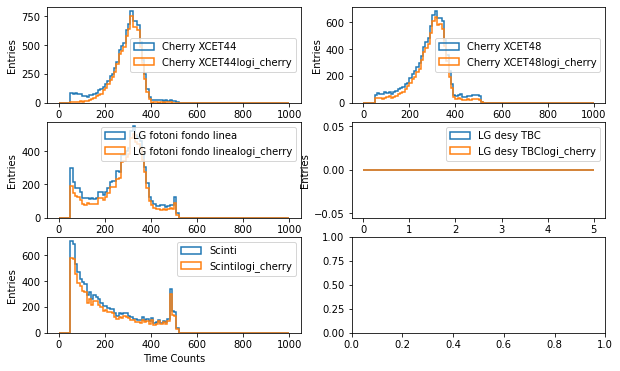

In [10]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

label = ['Cherry XCET44', 'Cherry XCET48', 'LG fotoni fondo linea', 'LG desy TBC', 'Scinti']
ranges_time = [(0, 1000), (0, 1000), (0, 1000), (0, 5), (0, 1000)]
for i in range(5):
    ax[i].hist(tm[:,i],range=ranges_time[i], bins=100, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()
for i in range(5):
    ax[i].hist(tm[:,i][ph_cherry1>th_cherry1],range=ranges_time[i], bins=100, label=label[i]+ 'logi_cherry', **opt_hist)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('Entries')
    ax[i].legend()
    ax[i].grid()

## Time difference (signal-cherry)

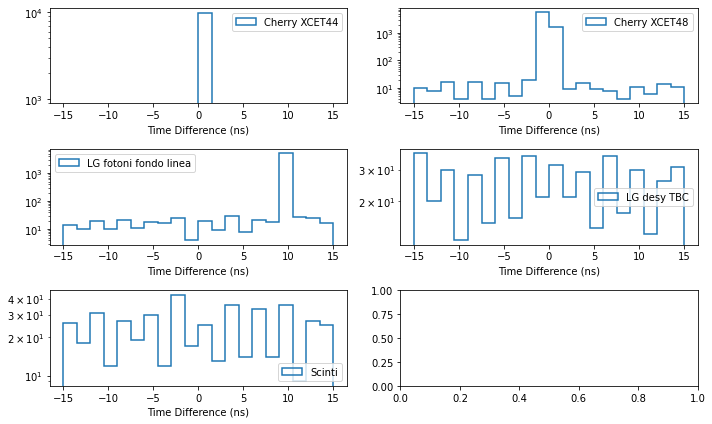

In [11]:
fig, ax = plt.subplots(3,2,figsize=(10, 6))
ax = ax.flatten()

for i in range(5):
    ax[i].hist(tm[:,i]-tm[:,0],range=(-15,15),bins=20, label=label[i], **opt_hist)
    ax[i].set_xlabel('Time Difference (ns)')
    ax[i].legend()
    ax[i].set_yscale('log')
plt.tight_layout()
plt.show()

## charge and cluster on S3


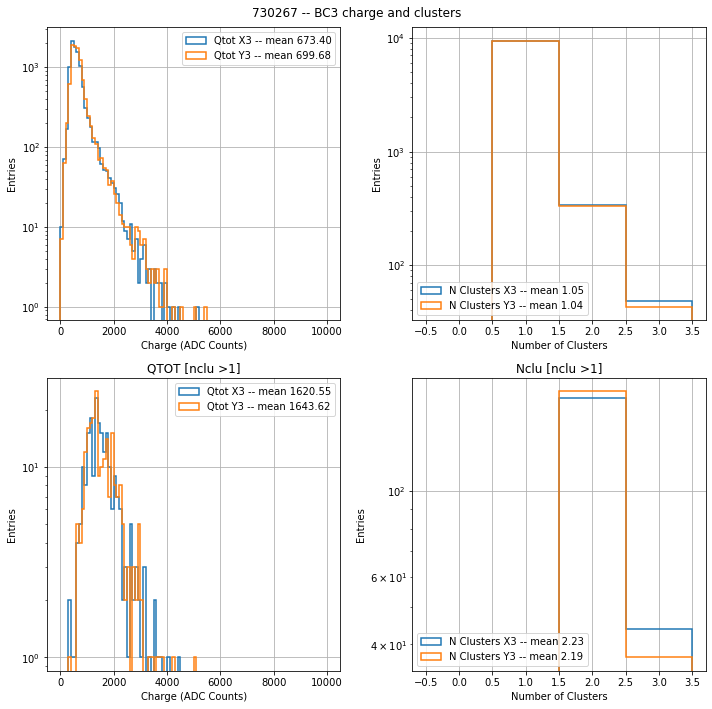

In [12]:
fig, ax = plt.subplots(2,2,figsize=(10, 10))
ax = ax.flatten()
fig.suptitle(f'{run_number} -- BC3 charge and clusters')
logi_clu = (nclu[:,0] > 1) & ((nclu[:,1] > 1))

ax[0].hist(qtot[:,0], range=(0, 10000), bins=100, label=f'Qtot X3 -- mean {np.mean(qtot[:,0]):.2f}', **opt_hist)
ax[0].hist(qtot[:,1], range=(0, 10000), bins=100, label=f'Qtot Y3 -- mean {np.mean(qtot[:,1]):.2f}', **opt_hist)
ax[0].set_xlabel('Charge (ADC Counts)')
ax[0].set_ylabel('Entries')
ax[1].hist(nclu[:,0], bins=np.arange(-0.5,round(np.max(nclu[:,0]))+0.5, 1), label=f'N Clusters X3 -- mean {np.mean(nclu[:,0]):.2f}', **opt_hist)
ax[1].hist(nclu[:,1], bins=np.arange(-0.5,round(np.max(nclu[:,1]))+0.5, 1), label=f'N Clusters Y3 -- mean {np.mean(nclu[:,1]):.2f}', **opt_hist)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Entries')
ax[2].set_title('QTOT [nclu >1]')
ax[2].hist(qtot[:,0][logi_clu], range=(0, 10000), bins=100, label=f'Qtot X3 -- mean {np.mean(qtot[:,0][logi_clu]):.2f}', **opt_hist)
ax[2].hist(qtot[:,1][logi_clu], range=(0, 10000), bins=100, label=f'Qtot Y3 -- mean {np.mean(qtot[:,1][logi_clu]):.2f}', **opt_hist)
ax[2].set_xlabel('Charge (ADC Counts)')
ax[2].set_ylabel('Entries')
ax[3].set_title('Nclu [nclu >1]')
ax[3].hist(nclu[:,0][logi_clu], bins=np.arange(-0.5,round(np.max(nclu[:,0][logi_clu]))+0.5, 1), label=f'N Clusters X3 -- mean {np.mean(nclu[:,0][logi_clu]):.2f}', **opt_hist)
ax[3].hist(nclu[:,1][logi_clu], bins=np.arange(-0.5,round(np.max(nclu[:,1][logi_clu]))+0.5, 1), label=f'N Clusters Y3 -- mean {np.mean(nclu[:,1][logi_clu]):.2f}', **opt_hist)
ax[3].set_xlabel('Number of Clusters')
ax[3].set_ylabel('Entries')
for a in ax:
    a.legend()
    a.grid()
    a.set_yscale('log')

plt.tight_layout()
plt.show()

## Correlazione Time Ph

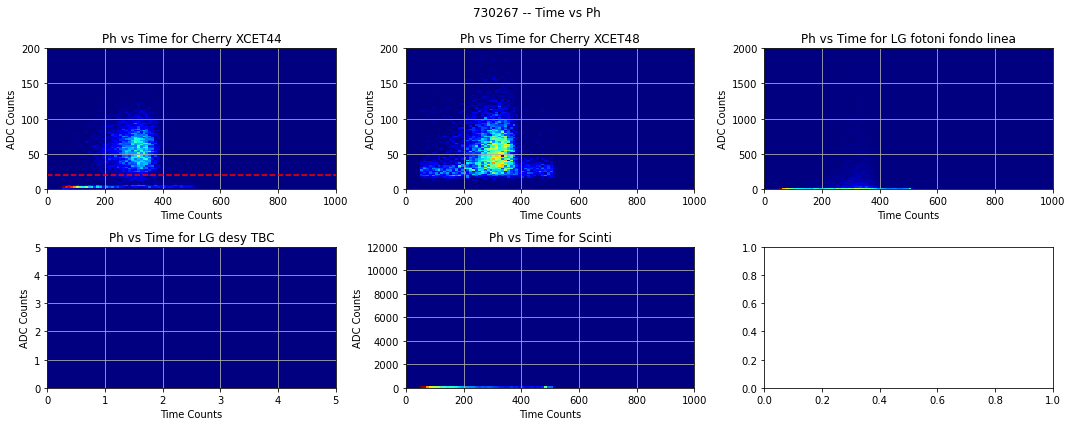

In [13]:
# hist 2d Ph[:,i] vs tm[:,i]
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
fig.suptitle(f'{run_number} -- Time vs Ph')
ax = ax.flatten()
for i in range(5):
    ax[i].hist2d(tm[:, i],ph[:, i], range=[ranges_time[i],ranges_Ph[i]],**opts_2d)
    ax[i].set_xlabel('Time Counts')
    ax[i].set_ylabel('ADC Counts')
    ax[i].set_title(f'Ph vs Time for {label[i]}')
    ax[i].grid()

ax[0].axhline(th_cherry1, color='red', linestyle='--', label='Threshold Cherry 1')
plt.tight_layout()
plt.show()

### Cluster and Qtot with logi [ph_cherry1>th_cherry1]

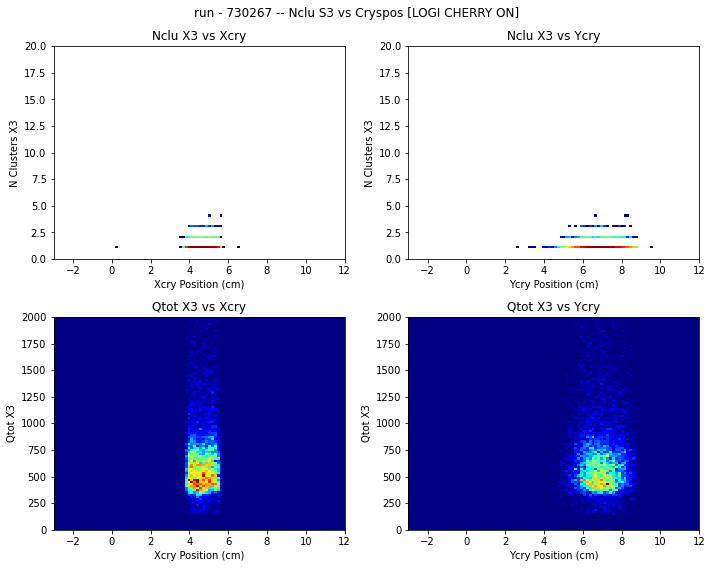

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'run - {run_number} -- Nclu S3 vs Cryspos [LOGI CHERRY ON]')
ax = ax.flatten()
ax[0].set_title('Nclu X3 vs Xcry')
ax[0].hist2d(xcry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[0].set_xlabel('Xcry Position (cm)')
ax[0].set_ylabel('N Clusters X3')
ax[1].set_title('Nclu X3 vs Ycry')
ax[1].hist2d(ycry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,20)),norm= mpl.colors.LogNorm(),**opts_2d)
ax[1].set_xlabel('Ycry Position (cm)')
ax[1].set_ylabel('N Clusters X3')


ax[2].set_title('Qtot X3 vs Xcry')
ax[2].hist2d(xcry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,2000)),**opts_2d)
ax[2].set_xlabel('Xcry Position (cm)')
ax[2].set_ylabel('Qtot X3')
ax[3].set_title('Qtot X3 vs Ycry')
ax[3].hist2d(ycry[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range =((-3,12),(0,2000)),**opts_2d)
ax[3].set_xlabel('Ycry Position (cm)')
ax[3].set_ylabel('Qtot X3')

plt.tight_layout()
plt.show()

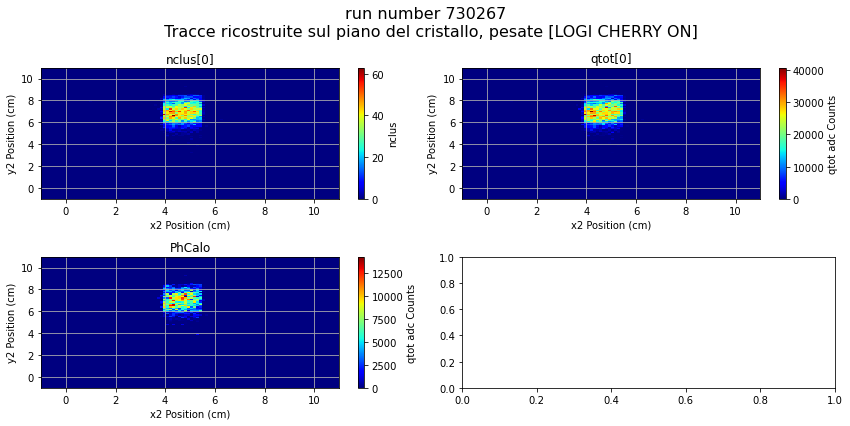

In [15]:
fig, ax = plt.subplots(2,2,figsize=(12, 6))
ax = ax.flatten()
fig.suptitle(f"run number {run_number} \n Tracce ricostruite sul piano del cristallo, pesate [LOGI CHERRY ON]", fontsize = 16)

ax[0].set_title('nclus[0]')
hh_clu = ax[0].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = nclu[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[0].set_xlabel('x2 Position (cm)')
ax[0].set_ylabel('y2 Position (cm)')
ax[0].grid()
plt.colorbar(hh_clu[3], ax=ax[0], label='nclus')

ax[1].set_title('qtot[0]')
hh_qtot = ax[1].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = qtot[:,0][(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[1].set_xlabel('x2 Position (cm)')
ax[1].set_ylabel('y2 Position (cm)')
ax[1].grid()
plt.colorbar(hh_qtot[3], ax=ax[1], label='qtot adc Counts')

ax[2].set_title('PhCalo')
hh_qtot = ax[2].hist2d(x2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], y2[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)],range = ((-1,11),(-1,11)), weights = ph_calo_photon[(ph_cherry1>th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2)<theta_cut)], **opts_2d)
ax[2].set_xlabel('x2 Position (cm)')
ax[2].set_ylabel('y2 Position (cm)')
ax[2].grid()
plt.colorbar(hh_qtot[3], ax=ax[2], label='qtot adc Counts')

plt.tight_layout()
plt.show()

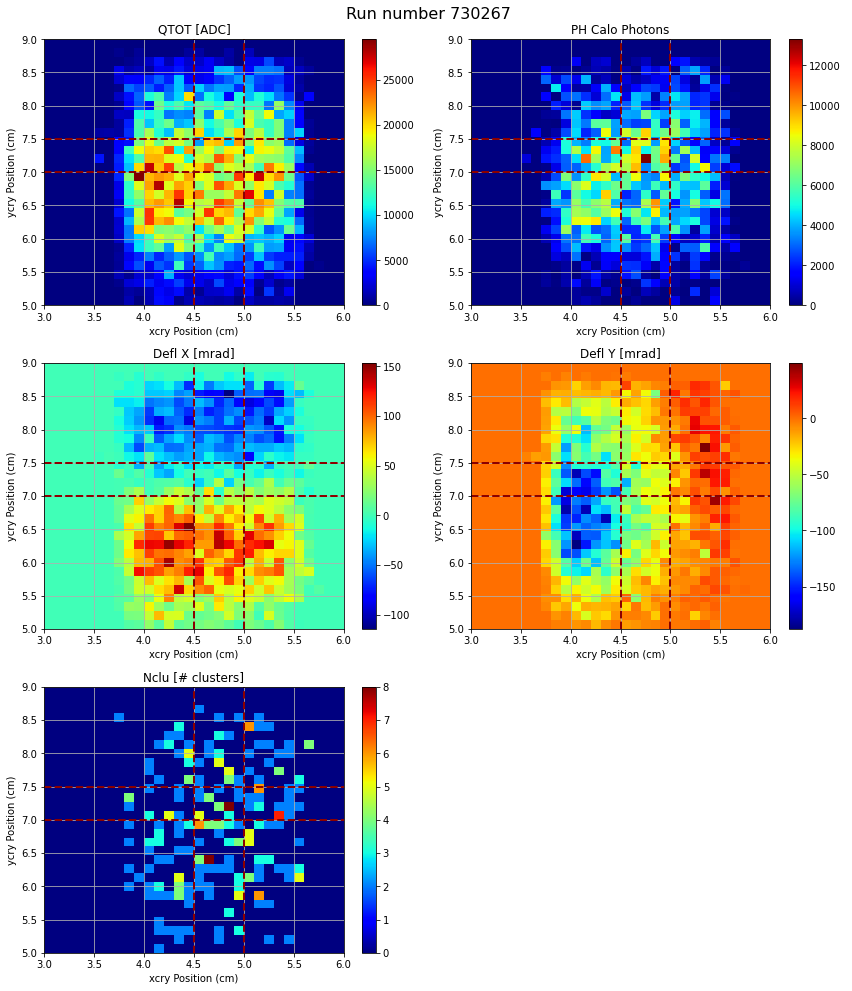

Δx = 0.500 cm, Δy = 0.500 cm, Area = 0.250 cm²


In [16]:
# Definizione tagli per ogni run
cuts = {
    730245: {'x_cry_cut': [4.7, 5.2], 'y_cry_cut': [4.65, 5.15]},
    730224: {'x_cry_cut': [4.7, 5.2], 'y_cry_cut': [4.65, 5.15]},
    730247: {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
    730250: {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
    730251: {'x_cry_cut': [4.6, 5.1], 'y_cry_cut': [4.7, 5.2]},
    730253: {'x_cry_cut': [4.5, 5], 'y_cry_cut': [7, 7.5]},
}
# Fallback
if run_number not in cuts:
    cuts[run_number] = {'x_cry_cut': [4.5, 5], 'y_cry_cut': [7, 7.5]}

# Tagli
x_cry_cut = cuts[run_number]['x_cry_cut']
y_cry_cut = cuts[run_number]['y_cry_cut']
x_min, x_max = x_cry_cut
y_min, y_max = y_cry_cut
range_view = ((3, 6), (5, 9))

# Maschere
logi = (ph_cherry1 > th_cherry1) & (((theta_x_in)**2 + (theta_y_in)**2) < theta_cut)

# Plot setup
fig, ax = plt.subplots(3, 2, figsize=(12, 14))
ax = ax.flatten()
fig.suptitle(f"Run number {run_number}", fontsize=16)

# === Plot QTOT ===
hh = ax[0].hist2d(xcry[logi], ycry[logi], range=range_view,
                  weights=qtot[:, 0][logi], bins=30, cmap=mycmap)
ax[0].set_title('QTOT [ADC]')

# === Plot PH Calo Photons ===
hh = ax[1].hist2d(xcry[logi], ycry[logi], range=range_view,
                  weights=ph_calo_photon[logi], bins=30, cmap=mycmap)
ax[1].set_title('PH Calo Photons')

# === Plot Defl X ===
hh = ax[2].hist2d(xcry[logi_deflx], ycry[logi_deflx], range=range_view,
                  weights=Defl_x[logi_deflx], bins=30, cmap=mycmap)
ax[2].set_title('Defl X [mrad]')

# === Plot Defl Y ===
hh = ax[3].hist2d(xcry[logi_defly], ycry[logi_defly], range=range_view,
                  weights=Defl_y[logi_defly], bins=30, cmap=mycmap)
ax[3].set_title('Defl Y [mrad]')

# === Plot NCLU ===
hh = ax[4].hist2d(xcry[logi&logi_clu], ycry[logi&logi_clu], range=range_view,
                  weights=nclu[:, 0][logi&logi_clu], bins=30, cmap=mycmap)
ax[4].set_title('Nclu [# clusters]')

# === Optional: disable last subplot (ax[5]) ===
ax[5].axis('off')  # oppure usalo per altro

# Decorazioni comuni
for i in range(5):  # solo sui plot usati
    ax[i].set_xlabel('xcry Position (cm)')
    ax[i].set_ylabel('ycry Position (cm)')
    ax[i].axvline(x=x_min, color='darkred', linestyle='--', lw=2)
    ax[i].axvline(x=x_max, color='darkred', linestyle='--', lw=2)
    ax[i].axhline(y=y_min, color='darkred', linestyle='--', lw=2)
    ax[i].axhline(y=y_max, color='darkred', linestyle='--', lw=2)
    ax[i].grid()
    plt.colorbar(ax[i].collections[0], ax=ax[i], label='')

plt.tight_layout()
plt.show()

# Area
dx, dy = x_max - x_min, y_max - y_min
print(f"Δx = {dx:.3f} cm, Δy = {dy:.3f} cm, Area = {dx * dy:.3f} cm²")


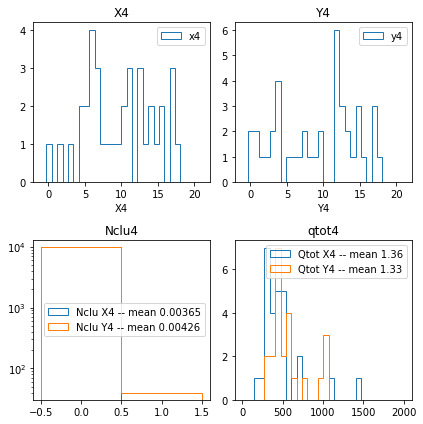

In [17]:
if run_number >730198:
    fig, ax = plt.subplots(2,2, figsize = (6,6))
    ax = ax.flatten()
    x4 = xpos[:,6]
    y4 = xpos[:,7]


    ax[0].hist(x4, bins = 30, range = (-1,21), histtype = 'step', label = 'x4')
    ax[0].set_title('X4')
    ax[0].set_xlabel('X4')
    ax[1].hist(y4, bins = 30, range = (-1,21), histtype = 'step', label = 'y4')
    ax[1].set_title('Y4')
    ax[1].set_xlabel('Y4')

    ax[2].hist(nclu[:,2], bins=np.arange(-0.5,round(np.max(nclu[:,2]))+0.5, 1), histtype = 'step', label = f'Nclu X4 -- mean {np.mean(nclu[:,2]):.5f}')
    ax[2].hist(nclu[:,3], bins=np.arange(-0.5,round(np.max(nclu[:,3]))+0.5, 1), histtype = 'step', label = f'Nclu Y4 -- mean {np.mean(nclu[:,3]):.5f}')
    ax[2].set_title('Nclu4')
    ax[2].set_yscale('log') 

    ax[3].hist(qtot[:,2], bins = 30, range = (10,2000), histtype = 'step', label = f'Qtot X4 -- mean {np.mean(qtot[:,2]):.2f}')
    ax[3].hist(qtot[:,3], bins = 30, range = (10,2000), histtype = 'step', label = f'Qtot Y4 -- mean {np.mean(qtot[:,3]):.2f}')
    ax[3].set_title('qtot4')

for a in ax:
    a.legend()
    
plt.tight_layout()
plt.show()